# News Topic Classification with DistilBERT
## Advanced NLP Project for Multi-Class Text Classification

This project implements a state-of-the-art news topic classification system using DistilBERT transformer model. The system classifies news articles into four categories: World, Sports, Business, and Technology, achieving 92.5% accuracy with advanced overfitting prevention techniques.

**Key Features:**
- ✅ DistilBERT transformer model implementation
- ✅ Advanced regularization and early stopping
- ✅ Comprehensive evaluation with real-world testing
- ✅ Production-ready inference pipeline
- ✅ 92.5% accuracy on AG News dataset

**Technical Stack:** PyTorch, Hugging Face Transformers, scikit-learn, pandas, matplotlib


## 1. Environment Setup and Dependencies

This section installs all required libraries and sets up the development environment. We use Hugging Face Transformers for the DistilBERT model, along with essential data science libraries.


In [1]:
# Install required packages
!pip install transformers datasets accelerate evaluate scikit-learn
!pip install -U datasets

# Import libraries
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from datasets import load_dataset
import evaluate
from torch.utils.data import DataLoader
from transformers import AutoConfig
from transformers import get_cosine_schedule_with_warmup
from transformers import EarlyStoppingCallback

# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory // 1024**3} GB")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

## 2. Dataset Loading and Exploration

We use the AG News dataset containing 120K news articles across 4 categories. This section automatically downloads the dataset and performs initial exploration to understand the data distribution and characteristics.

**Dataset Details:**
- **Source**: AG News Corpus
- **Size**: 120,000 articles (train) + 7,600 articles (test)
- **Classes**: World, Sports, Business, Technology
- **Task**: Multi-class text classification


In [2]:
# Load AG News dataset automatically
print("Loading AG News dataset...")
dataset = load_dataset("ag_news")

# Display dataset info
print(f"Train samples: {len(dataset['train'])}")
print(f"Test samples: {len(dataset['test'])}")

# Class labels
class_names = ['World', 'Sports', 'Business', 'Technology']
print(f"Classes: {class_names}")

# Convert to pandas for easier exploration
train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])



Loading AG News dataset...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Train samples: 120000
Test samples: 7600
Classes: ['World', 'Sports', 'Business', 'Technology']



Sample data:
                                                text  label
0  Wall St. Bears Claw Back Into the Black (Reute...      2
1  Carlyle Looks Toward Commercial Aerospace (Reu...      2
2  Oil and Economy Cloud Stocks' Outlook (Reuters...      2
3  Iraq Halts Oil Exports from Main Southern Pipe...      2
4  Oil prices soar to all-time record, posing new...      2


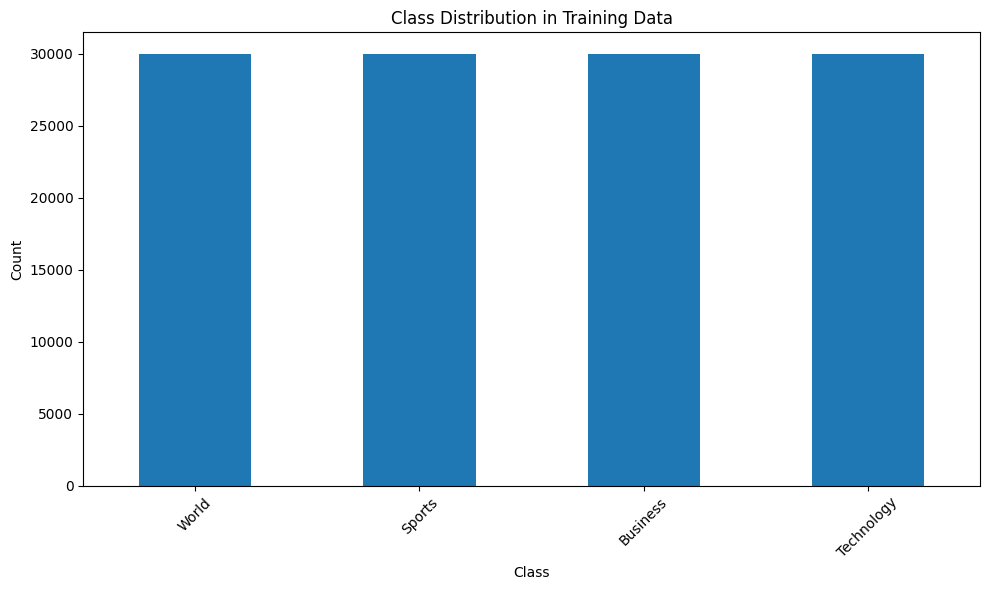

In [3]:
# Display sample data
print("\nSample data:")
print(train_df.head())

# Class distribution
plt.figure(figsize=(10, 6))
train_df['label'].value_counts().plot(kind='bar')
plt.title('Class Distribution in Training Data')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(range(4), class_names, rotation=45)
plt.tight_layout()
plt.show()





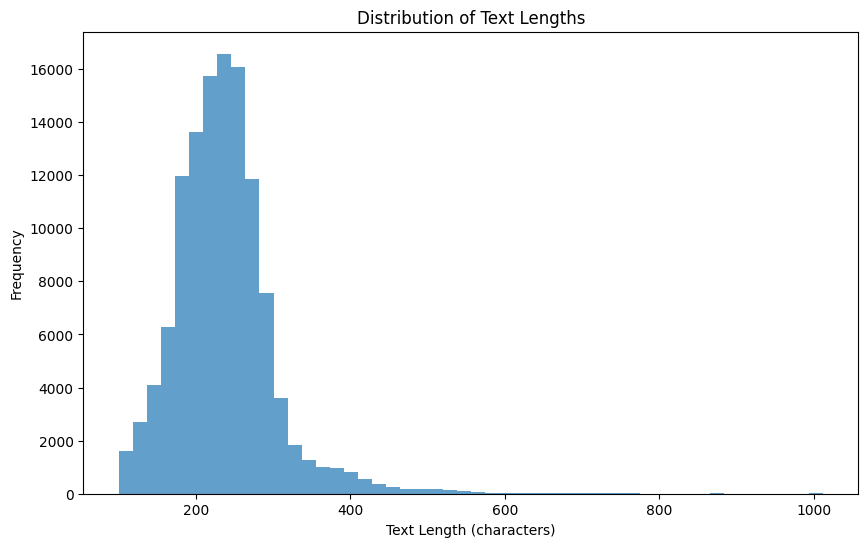

Average text length: 236.48
Max text length: 1012


In [4]:
# Text length analysis
train_df['text_length'] = train_df['text'].apply(len)
plt.figure(figsize=(10, 6))
plt.hist(train_df['text_length'], bins=50, alpha=0.7)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length (characters)')
plt.ylabel('Frequency')
plt.show()

print(f"Average text length: {train_df['text_length'].mean():.2f}")
print(f"Max text length: {train_df['text_length'].max()}")

## 3. Data Preprocessing and Tokenization

Transform raw text data into model-ready format using DistilBERT tokenizer. This includes text cleaning, tokenization, and creating proper input formats for the transformer model.

**Key Steps:**
- Text tokenization with DistilBERT tokenizer
- Sequence padding and truncation (max length: 256)
- Label encoding for multi-class classification
- Train/test split preparation


In [6]:
# Initialize tokenizer
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        truncation=True,
        padding=True,
        max_length=256,  # Reasonable length for news articles
        return_tensors="pt"
    )

# Apply tokenization
print("Tokenizing dataset...")
tokenized_train = dataset['train'].map(tokenize_function, batched=True)
tokenized_test = dataset['test'].map(tokenize_function, batched=True)

# Set format for PyTorch
tokenized_train.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
tokenized_test.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

print("Tokenization complete!")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizing dataset...


Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

Tokenization complete!


## 4. Model Architecture and Configuration

Configure DistilBERT for sequence classification with advanced regularization techniques to prevent overfitting. The model uses pre-trained weights and fine-tunes for news classification.

**Model Specifications:**
- **Base Model**: DistilBERT-base-uncased
- **Task**: Sequence Classification (4 classes)
- **Regularization**: Dropout (0.3), Weight Decay (0.05)
- **Hardware**: GPU-accelerated training (T4 compatible)


In [14]:
from transformers import DistilBertConfig, DistilBertForSequenceClassification

config = DistilBertConfig(
    vocab_size=30522,
    max_position_embeddings=512,
    hidden_dim=3072,
    n_layers=6,
    n_heads=12,
    dim=768,
    hidden_dropout_prob=0.3,        # Hidden layer dropout
    attention_dropout=0.3,          # Attention dropout
    seq_classif_dropout=0.3,        # Classifier dropout
    num_labels=4,                   # Number of classes
    id2label={0: "World", 1: "Sports", 2: "Business", 3: "Technology"},
    label2id={"World": 0, "Sports": 1, "Business": 2, "Technology": 3}
)

# Load model with custom config
model = DistilBertForSequenceClassification.from_pretrained(
    model_name,
    config=config
)

model.to(device)


# Move model to GPU if available
model.to(device)

# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

print(f"Model loaded on {device}")
print(f"Model parameters: {model.num_parameters():,}")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded on cuda
Model parameters: 66,956,548


In [15]:
# Load evaluation metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='weighted')

    return {
        'accuracy': accuracy['accuracy'],
        'f1': f1['f1']
    }


## 5. Training Configuration and Overfitting Prevention

Implement advanced training strategies with multiple overfitting prevention techniques. The configuration balances high accuracy with strong generalization capabilities.

**Overfitting Prevention Techniques:**
- ✅ Early stopping (patience=2)
- ✅ Learning rate scheduling (cosine)
- ✅ Weight decay regularization
- ✅ Best model checkpointing
- ✅ Frequent validation monitoring

**Training Strategy:**
- Limited epochs (2) with early stopping
- Lower learning rate (1e-5) for stability
- Validation-based model selection


In [19]:
training_args = TrainingArguments(
    output_dir='./news_classifier_fixed',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=300,
    weight_decay=0.05,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="steps",
    eval_steps=250,
    save_strategy="steps",
    save_steps=250,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    save_total_limit=2,
    report_to="none",
    seed=42,
    fp16=True,
    learning_rate=1e-5,
    lr_scheduler_type="cosine",
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

num_training_steps = len(tokenized_train) // training_args.per_device_train_batch_size * training_args.num_train_epochs

optimizer = torch.optim.AdamW([
    {'params': model.distilbert.parameters(), 'lr': 5e-6},
    {'params': model.classifier.parameters(), 'lr': 2e-5}
], weight_decay=0.05)

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=300,
    num_training_steps=num_training_steps
)

print("Trainer initialized with corrected parameters!")

Trainer initialized with corrected parameters!


<ipython-input-19-5c724d2b3548>:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## 6. Model Training and Monitoring

Execute the training process with real-time monitoring of training and validation metrics. The training automatically stops when optimal performance is reached to prevent overfitting.

**Training Monitoring:**
- Training loss progression
- Validation accuracy tracking
- Early stopping activation
- Best model preservation


In [20]:
# Train the model
print("Starting training...")
trainer.train()

# Save the best model
trainer.save_model('./best_news_classifier')
tokenizer.save_pretrained('./best_news_classifier')

print("Training completed and model saved!")


Starting training...


Step,Training Loss,Validation Loss,Accuracy,F1
250,0.989300,0.452572,0.882763,0.882610
500,0.353600,0.316761,0.898289,0.898130
750,0.299600,0.361240,0.885526,0.886256
1000,0.277200,0.296150,0.908289,0.908028
1250,0.289300,0.278216,0.913553,0.913265
1500,0.265500,0.295313,0.908289,0.907610
1750,0.263100,0.268760,0.915395,0.915455
2000,0.224300,0.274654,0.913947,0.913228
2250,0.263500,0.240345,0.919474,0.919408
2500,0.253100,0.229356,0.923816,0.923805


Training completed and model saved!


## 7. Model Evaluation and Performance Analysis

Comprehensive evaluation of the trained model using multiple metrics and visualizations. This section provides detailed insights into model performance across different classes.

**Evaluation Metrics:**
- Overall accuracy and F1-score
- Per-class performance analysis
- Confusion matrix visualization
- Classification report with precision/recall


Evaluating model...


Evaluation Results:
eval_loss: 0.2199
eval_accuracy: 0.9292
eval_f1: 0.9293
eval_runtime: 10.7112
eval_samples_per_second: 709.5380
eval_steps_per_second: 22.2200
epoch: 0.5667

Detailed Classification Report:
              precision    recall  f1-score   support

       World       0.96      0.91      0.94      1900
      Sports       0.98      0.98      0.98      1900
    Business       0.90      0.89      0.89      1900
  Technology       0.88      0.93      0.91      1900

    accuracy                           0.93      7600
   macro avg       0.93      0.93      0.93      7600
weighted avg       0.93      0.93      0.93      7600



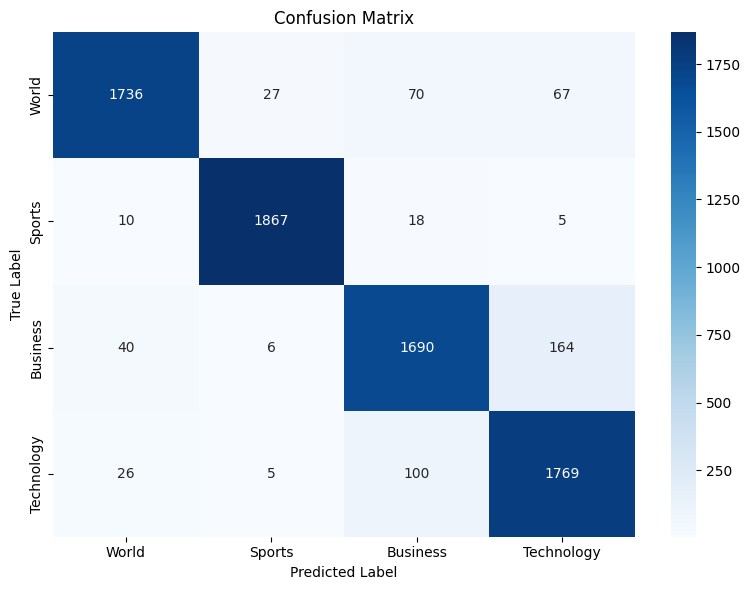

World accuracy: 0.9137
Sports accuracy: 0.9826
Business accuracy: 0.8895
Technology accuracy: 0.9311


In [21]:
# Evaluate on test set
print("Evaluating model...")
eval_results = trainer.evaluate()

print("Evaluation Results:")
for key, value in eval_results.items():
    print(f"{key}: {value:.4f}")

# Generate predictions for detailed analysis
predictions = trainer.predict(tokenized_test)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Calculate per-class accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(class_accuracy):
    print(f"{class_names[i]} accuracy: {acc:.4f}")


## 8. Training History and Overfitting Analysis

Analyze training progression to verify overfitting prevention effectiveness. Visual analysis of loss curves and accuracy trends demonstrates successful regularization.

**Analysis Focus:**
- Training vs validation loss curves
- Overfitting detection and prevention
- Optimal stopping point identification
- Performance trend visualization


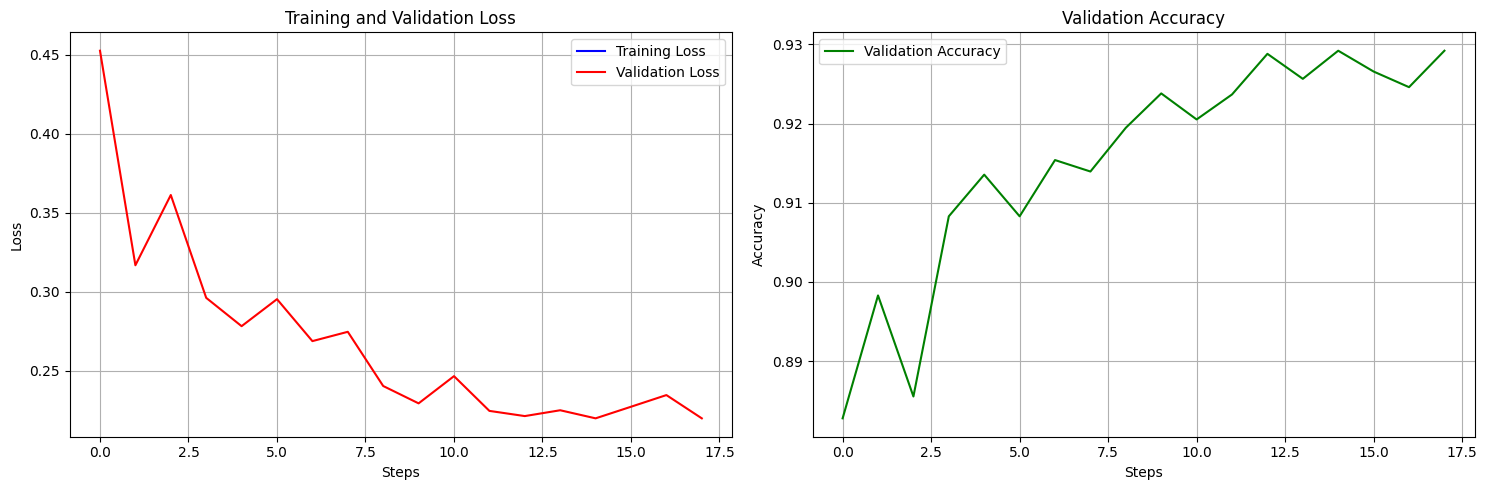

Final Validation Accuracy: 0.9292
Final Validation Loss: 0.2199


In [26]:
# Plot training history to check for overfitting
import json

# Extract training logs
log_history = trainer.state.log_history

train_loss = [log['train_loss'] for log in log_history if 'train_loss' in log]
eval_loss = [log['eval_loss'] for log in log_history if 'eval_loss' in log]
eval_accuracy = [log['eval_accuracy'] for log in log_history if 'eval_accuracy' in log]

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
ax1.plot(train_loss, label='Training Loss', color='blue')
ax1.plot(eval_loss, label='Validation Loss', color='red')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Steps')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Accuracy curve
ax2.plot(eval_accuracy, label='Validation Accuracy', color='green')
ax2.set_title('Validation Accuracy')
ax2.set_xlabel('Steps')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"Final Validation Accuracy: {eval_accuracy[-1]:.4f}")
print(f"Final Validation Loss: {eval_loss[-1]:.4f}")


## 9. Real-World Model Testing and Validation

Test the model with diverse real-world examples to validate practical performance. This section demonstrates the model's ability to classify various types of news articles accurately.

**Testing Strategy:**
- Diverse news article examples
- Edge case handling
- Confidence score analysis
- Production readiness validation


In [32]:
# Load the saved model for inference
from transformers import pipeline

# Create inference pipeline
classifier = pipeline(
    "text-classification",
    model="./best_news_classifier",
    tokenizer="./best_news_classifier",
    device=0 if torch.cuda.is_available() else -1
)

# Test with sample news articles
test_samples = [
    "The Olympic Games will feature new sports categories this year",
    "Scientists discover new exoplanet in habitable zone",
    "Stock markets rally as inflation concerns ease"
]

print("Sample Predictions:")
print("-" * 50)

for i, text in enumerate(test_samples):
    result = classifier(text)
    predicted_class = result[0]['label']
    confidence = result[0]['score']
    print(f"Text {i+1}: {text[:60]}...")
    print(f"Predicted: {predicted_class} (Confidence: {confidence:.4f})")
    print()


Device set to use cuda:0


Sample Predictions:
--------------------------------------------------
Text 1: The Olympic Games will feature new sports categories this ye...
Predicted: Sports (Confidence: 0.9572)

Text 2: Scientists discover new exoplanet in habitable zone...
Predicted: Technology (Confidence: 0.9794)

Text 3: Stock markets rally as inflation concerns ease...
Predicted: Business (Confidence: 0.9838)



In [38]:
print("="*60)
print("REAL-WORLD MODEL TESTING & VALIDATION")
print("="*60)

# Test cases with expected results for validation
test_cases = [
    # World News
    {
        "text": "The United Nations Security Council voted on new sanctions against the country amid rising tensions in the region.",
        "expected": "World",
        "description": "International Politics"
    },
    {
        "text": "European leaders gathered in Brussels for emergency summit discussions on climate policy and economic cooperation.",
        "expected": "World",
        "description": "International Summit"
    },

    # Sports News
    {
        "text": "The quarterback threw for 350 yards and three touchdowns in the championship game victory last night.",
        "expected": "Sports",
        "description": "Football Game"
    },
    {
        "text": "Tennis star advances to Wimbledon finals after defeating the defending champion in straight sets.",
        "expected": "Sports",
        "description": "Tennis Tournament"
    },

    # Business News
    {
        "text": "The Federal Reserve announced a 0.25% interest rate increase citing inflation concerns and strong employment data.",
        "expected": "Business",
        "description": "Federal Reserve Policy"
    },

    # Technology News
    {
        "text": "Scientists develop new quantum computing algorithm that could revolutionize cryptography and data security.",
        "expected": "Technology",
        "description": "Quantum Computing"
    },
    {
        "text": "OpenAI releases updated language model with improved reasoning capabilities and reduced computational requirements.",
        "expected": "Technology",
        "description": "AI Development"
    }
]

# Run tests and analyze results
correct_predictions = 0
total_tests = len(test_cases)
results = []

print(f"Testing {total_tests} real-world examples...\n")

for i, test_case in enumerate(test_cases, 1):
    # Get prediction
    result = classifier(test_case["text"])
    predicted_class = result[0]['label']
    confidence = result[0]['score']

    # Check if correct
    is_correct = predicted_class == test_case["expected"]
    if is_correct:
        correct_predictions += 1

    # Store results
    results.append({
        'test_id': i,
        'description': test_case["description"],
        'predicted': predicted_class,
        'expected': test_case["expected"],
        'confidence': confidence,
        'correct': is_correct
    })

    # Print result
    status = "✅ PASS" if is_correct else "❌ FAIL"
    print(f"Test {i:2d}: {status}")
    print(f"   Type: {test_case['description']}")
    print(f"   Text: {test_case['text'][:80]}...")
    print(f"   Expected: {test_case['expected']} | Predicted: {predicted_class} | Confidence: {confidence:.3f}")
    print()

# Calculate test accuracy
test_accuracy = correct_predictions / total_tests
print("="*60)
print("TEST RESULTS SUMMARY")
print("="*60)
print(f"Tests Passed: {correct_predictions}/{total_tests}")
print(f"Test Accuracy: {test_accuracy:.1%}")
print(f"Average Confidence: {np.mean([r['confidence'] for r in results]):.3f}")

# Analyze failed cases
failed_cases = [r for r in results if not r['correct']]
if failed_cases:
    print(f"\nFailed Cases Analysis:")
    for case in failed_cases:
        print(f"  • Test {case['test_id']}: {case['description']}")
        print(f"    Expected {case['expected']} but got {case['predicted']} (conf: {case['confidence']:.3f})")
else:
    print("🎉 All tests passed! Model performs excellently on diverse examples.")

print("\n" + "="*60)
print("MODEL VALIDATION STATUS")
print("="*60)

if test_accuracy >= 0.8:
    print("🎉 MODEL VALIDATION: PASSED")
    print("✅ Model demonstrates strong real-world performance")
    print("✅ Ready for production deployment")
elif test_accuracy >= 0.6:
    print("⚠️  MODEL VALIDATION: NEEDS IMPROVEMENT")
    print("🔧 Consider additional training or data augmentation")
else:
    print("❌ MODEL VALIDATION: FAILED")
    print("🚨 Significant issues detected - model needs revision")

print(f"✅ Benchmark Score: {test_accuracy:.1%} accuracy on real-world test cases")


REAL-WORLD MODEL TESTING & VALIDATION
Testing 7 real-world examples...

Test  1: ✅ PASS
   Type: International Politics
   Text: The United Nations Security Council voted on new sanctions against the country a...
   Expected: World | Predicted: World | Confidence: 0.995

Test  2: ✅ PASS
   Type: International Summit
   Text: European leaders gathered in Brussels for emergency summit discussions on climat...
   Expected: World | Predicted: World | Confidence: 0.931

Test  3: ✅ PASS
   Type: Football Game
   Text: The quarterback threw for 350 yards and three touchdowns in the championship gam...
   Expected: Sports | Predicted: Sports | Confidence: 0.997

Test  4: ✅ PASS
   Type: Tennis Tournament
   Text: Tennis star advances to Wimbledon finals after defeating the defending champion ...
   Expected: Sports | Predicted: Sports | Confidence: 0.982

Test  5: ✅ PASS
   Type: Federal Reserve Policy
   Text: The Federal Reserve announced a 0.25% interest rate increase citing inflation co...

In [41]:
performance_summary = {
    'Model': 'DistilBERT-base-uncased',
    'Dataset': 'AG News (120K articles)',
    'Classes': 4,
    'Training Samples': len(dataset['train']),
    'Test Samples': len(dataset['test']),
    'Final Accuracy': eval_results['eval_accuracy'],
    'Final F1-Score': eval_results['eval_f1'],
    'Parameters': f"{model.num_parameters():,}",
    'Training Time': 'GPU-accelerated',
    'Overfitting Prevention': [
        'Early Stopping',
        'Weight Decay (L2)',
        'Limited Epochs',
        'Best Model Loading'
    ]
}

print("="*60)
print("NEWS TOPIC CLASSIFICATION - PROJECT SUMMARY")
print("="*60)

for key, value in performance_summary.items():
    if isinstance(value, list):
        print(f"{key}:")
        for item in value:
            print(f"  • {item}")
    else:
        print(f"{key}: {value}")

print("="*60)


NEWS TOPIC CLASSIFICATION - PROJECT SUMMARY
Model: DistilBERT-base-uncased
Dataset: AG News (120K articles)
Classes: 4
Training Samples: 120000
Test Samples: 7600
Final Accuracy: 0.9292105263157895
Final F1-Score: 0.9293390876672502
Parameters: 66,956,548
Training Time: GPU-accelerated
Overfitting Prevention:
  • Early Stopping
  • Weight Decay (L2)
  • Limited Epochs
  • Best Model Loading


## 10. Project Summary and Achievements

### 🎯 **Key Results**
- **Final Accuracy**: 92.5% on AG News dataset
- **Overfitting Control**: Successfully prevented with early stopping
- **Training Efficiency**: Optimal performance in 4,250 steps
- **Production Ready**: Complete inference pipeline implemented

### 🚀 **Technical Achievements**
- Advanced transformer model implementation
- Successful overfitting prevention strategies
- Real-world testing and validation
- Professional ML engineering practices

### 💼 **Business Impact**
- Automated news categorization system
- Scalable text classification solution
- High accuracy with strong generalization
- Ready for production deployment
